In [1]:
import xarray as xr
import numpy as np
import sys, time
import matplotlib.pyplot as plt
sys.path.append( '/groups/sylvia/JAS-MCS-rain/' )
from thermodynamic_functions import satVapP_liq
#from dask.distributed import Client, progress, wait

import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib import cm
from matplotlib import colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
eps = 0.01802/0.02897 # ratio of MW_water to MW_air
g = 9.8 # [m s-2] gravitational acceleration
R_air = 287.058 # [J kg-1 K-1]
basedir = '/xdisk/sylvia/DYAMOND-UM/'
pressh_file = basedir + 'phalf_3hr_HadGEM3-GA71_N2560_20160801-20160908_Asia.nc'
pressf_file = basedir + 'pfull_3hr_HadGEM3-GA71_N2560_20160801-20160908_Asia.nc'

In [3]:
# set whether we use full or half pressure levels in the analysis below
which_pressures = 'full' # 'half'

### Start by regridding the 3D files from model levels to pressure levels

### Reading in regridded 3D files and pressure levels

In [4]:
# 3D pressure level HadGEM data from DYAMOND
# vertical velocity [m s-1], temperature [K], 
# suffixed _PLfull or _PLhalf based on which pressure file they were regridded from
w_pfile = basedir + 'Asia-PL' + which_pressures + '/wa_3hr_HadGEM3-GA71_N2560_20160801-20160908_Asia_PL' + which_pressures + '.nc'
t_pfile = basedir + 'Asia-PL' + which_pressures + '/ta_3hr_HadGEM3-GA71_N2560_20160801-20160908_Asia_PL' + which_pressures + '.nc'
qv_pfile = basedir + 'Asia-PL' + which_pressures + '/hus_3hr_HadGEM3-GA71_N2560_20160801-20160908_Asia_PL' + which_pressures + '.nc'
#cli_file = basedir + 'Asia-PL' + which_pressures + '/cli_3hr_HadGEM3-GA71_N2560_20160801-20160908_Asia_PL' + which_pressures + '.nc'
#clw_file = basedir + 'Asia-PL' + which_pressures + '/clw_3hr_HadGEM3-GA71_N2560_20160801-20160908_Asia_PL' + which_pressures + '.nc'
pfile = '/groups/sylvia/JAS-MCS-rain/DYAMOND/mean_p' + which_pressures + '_3hr_HadGEM3-GA71_N2560_20160801-20160908_Asia.txt'

In [5]:
# dimensions for the variables going into the scaling
zeit = xr.open_dataset(w_pfile)['time']        # every 3 hours for 39 days (312 values)
lats = xr.open_dataset(w_pfile)['latitude']    # -5 to 40 (960 values)
lons = xr.open_dataset(w_pfile)['longitude']   # 55 to 115 (854 values)

In [6]:
# variables going into the scaling -- vertical velocity, temperature, specific humidity
w_HadGEM = xr.open_dataset(w_pfile)['upward_air_velocity']  # (312 times, 55 levels, 960 lat, 854 lon)
T_HadGEM = xr.open_dataset(t_pfile)['air_temperature']
qv_HadGEM = xr.open_dataset(qv_pfile)['specific_humidity']

# variable for integration
press_HadGEM = xr.DataArray( np.loadtxt( pfile ), coords={'model_level_number': np.arange(1,56)} )

In [7]:
press_HadGEM_full = xr.broadcast( press_HadGEM, qv_HadGEM[0] )[0]

# Set the vertical coordinate for all variables to pressure levels
qv_HadGEM = qv_HadGEM.assign_coords( model_level_number=press_HadGEM ).rename( {'model_level_number': 'pressure_level'})
press_HadGEM_full = press_HadGEM_full.assign_coords( model_level_number=press_HadGEM ).rename( {'model_level_number': 'pressure_level'})
w_HadGEM = w_HadGEM.assign_coords( model_level_number=press_HadGEM ).rename( {'model_level_number': 'pressure_level'})
T_HadGEM = T_HadGEM.assign_coords( model_level_number=press_HadGEM ).rename( {'model_level_number': 'pressure_level'})

### Calculate the integrated condensation rate over the Asian monsoon domain

In [ ]:
cond_rate_HadGEM_alltimes = np.empty((312, 960, 854))

In [11]:
for i in np.arange(5):
    if i%10 == 0:
        print('Time point: ' + str(i))
    
    # Start by evaluating the saturation vapor mixing ratio from qv and T
    qvsat_HadGEM = eps * satVapP_liq(T_HadGEM[i]) / ( press_HadGEM_full - satVapP_liq(T_HadGEM[i]) )
    RH = qv_HadGEM[i] / qvsat_HadGEM

    # Then calculate the gradient versus pressure in that saturation vapor mixing ratio
    dqvsat_dp_HadGEM = qvsat_HadGEM.differentiate( 'pressure_level' )
    
    # Convert vertical velocity to pressure velocity
    rho_air = press_HadGEM_full / (R_air * T_HadGEM[i]) # [kg m-3]
    omega_HadGEM = -1.*w_HadGEM[i]*rho_air*g # [Pa s-1]
    
    # Multiply the gradient with respect to pressure by pressure velocity
    integrand = omega_HadGEM * dqvsat_dp_HadGEM / g
    print(integrand)
    
    # Determine the lifting condensation level, Lawrence BAMS 2005 approximation for Tdew
    Tmean = T_HadGEM[i].mean( dim={'latitude','longitude'} )
    Tdew = T_HadGEM[i,0] - ( (100 - 100*RH[0])/5 )
    Tdew = xr.broadcast( Tdew, Tmean )[0].mean( dim={'latitude','longitude'} )
    k = np.abs( Tmean - Tdew ).argmin( 'pressure_level' ).values
    # Eq (6.35) from Curry & Webster, z_LCL [=] km
    #z_LCL = 0.12*( T_HadGEM[i,0] - Tdew )
    
    # Determine the cold-point tropopause, 
    # i.e. where the temperature change becomes negative as the stratosphere warms
    j = np.argwhere( (Tmean[:-1].values-Tmean[1:].values) < 0 )[0,0]
    
    # Integrate the condensation rate over the pressures from the LCL up to the tropopause
    # From ERA-I analysis, typical values of condensation rate min / mean / max
    # -0.0001579 0.02461 0.02724 1.1056
    integrand = integrand[k:j-1]
    cond_rate_HadGEM_alltimes[i] = integrand.integrate( "pressure_level" )

#cond_rate_HadGEM_alltimes_xr = xr.Dataset( coords={'time': zeit, 'latitude': lats, 'longitude': lons} )
#cond_rate_HadGEM_alltimes_xr["cond_rate_avgbounds_PL" + which_pressures] = (["time", "latitude", "longitude"], cond_rate_HadGEM_alltimes)
#cond_rate_HadGEM_alltimes_xr.to_netcdf( '/groups/sylvia/JAS-MCS-rain/DYAMOND/cond_rate_HadGEM_avgbounds_PL' + which_pressures + '.nc' )

Time point: 0
<xarray.DataArray (pressure_level: 55, latitude: 960, longitude: 854)>
array([[[-5.83488303e-10, -4.40679408e-10, -5.72718590e-10, ...,
          7.61749207e-10,  2.49344815e-10, -1.62063084e-10],
        [-5.77926463e-10, -3.89607414e-10, -4.88909767e-10, ...,
          4.99044684e-10,  1.13390954e-10, -3.66533617e-10],
        [-7.40069186e-10, -6.19886364e-10, -6.65581731e-10, ...,
          4.27992193e-10, -7.77563777e-11, -3.24110652e-10],
        ...,
        [-2.47668431e-08, -4.09287483e-08, -2.85924424e-08, ...,
         -3.17236791e-07, -2.93230515e-07, -1.12916967e-07],
        [-3.07411409e-08, -4.87286354e-08, -3.51123097e-08, ...,
         -1.73319113e-07, -3.21599845e-07, -1.95205127e-07],
        [-2.02534318e-08, -3.39870934e-08, -3.63807239e-08, ...,
         -3.33500958e-08, -2.24631401e-07, -2.82243238e-07]],

       [[-1.49281799e-09, -1.14031334e-09, -1.53426313e-09, ...,
          1.96354056e-09,  6.38009876e-10, -4.11305267e-10],
        [-1.493489

NameError: name 'cond_rate_HadGEM_alltimes' is not defined

### Calculate the precipitation efficiency over the Asian monsoon domain

In [8]:
# Integrate the condensation rate over the pressures
# From ERA-I analysis, typical values of condensation rate min / mean / max
# -0.0001579 0.02461 0.02724 1.1056
#cond_rate_HadGEM = integrand.integrate( "pressure_level" )
file = xr.open_dataset( '/groups/sylvia/JAS-MCS-rain/DYAMOND/cond_rate_HadGEM_avgbounds_PL' + which_pressures + '.nc' )
cond_rate_HadGEM = file['cond_rate_avgbounds_PL' + which_pressures]
cond_rate_HadGEM_pos = xr.where( cond_rate_HadGEM > 0, cond_rate_HadGEM, np.nan )
cond_rate_HadGEM_pos_timeavg = cond_rate_HadGEM_pos.mean( skipna=True, dim="time" )

In [9]:
print( np.nanmin(cond_rate_HadGEM_pos), np.nanmedian(cond_rate_HadGEM_pos), np.nanmean(cond_rate_HadGEM_pos), np.nanmax(cond_rate_HadGEM_pos) )
print(cond_rate_HadGEM_pos.shape)
print(cond_rate_HadGEM_pos_timeavg.shape)

3.0556544773355574e-12 0.00027010858704135517 0.0007621587270502095 0.7621751722799931
(312, 960, 854)
(960, 854)


In [13]:
# There are two ways to calculate precip efficiency
# 1) take the time-averaged precip over the time-averaged integrated condensation rate
#precip_file = basedir + '/pr_15min_HadGEM3-GA71_N2560_20160801-20160908_Asia.nc'
precip_file = basedir + '/pr_timeavg_hadgem3-ga71_n2560_20160801-20160908_asia.nc'
precip_HadGEM_timeavg = xr.open_dataset(precip_file)['precipitation_flux'][0]
precip_eff_HadGEM = precip_HadGEM_timeavg / cond_rate_HadGEM_pos_timeavg
precip_eff_HadGEM.to_netcdf( '/groups/sylvia/JAS-MCS-rain/DYAMOND/precip_eff_HadGEM_avgbounds_PL' + which_pressures + '_noregrid.nc' )

# 2) take the efficiency value at every time step and then time average

In [14]:
print( np.nanmin(precip_eff_HadGEM), np.nanmedian(precip_eff_HadGEM), np.nanmean(precip_eff_HadGEM), np.nanmax(precip_eff_HadGEM) )
print(precip_eff_HadGEM.shape)

2.407270016971383e-06 0.09470472013325906 0.12260816983834566 1.3315421694318101
(960, 854)


### Calculate the precipitation efficiency over the Asian monsoon domain from regridded files

In [14]:
file = xr.open_dataset( '/groups/sylvia/JAS-MCS-rain/DYAMOND/cond_rate_HadGEM_avgbounds_PL' + which_pressures + '_0.10_grid.nc' )
cond_rate_HadGEM_regrid = file['cond_rate_avgbounds_PL' + which_pressures]
cond_rate_HadGEM_regrid_pos = xr.where( cond_rate_HadGEM_regrid > 0, cond_rate_HadGEM_regrid, np.nan )
cond_rate_HadGEM_regrid_pos_timeavg = cond_rate_HadGEM_regrid_pos.mean( skipna=True, dim="time" )

# take the time-averaged precip (regridded!) over the time-averaged integrated condensation rate (regridded!)
#precip_file = basedir + '/pr_15min_HadGEM3-GA71_N2560_20160801-20160908_Asia.nc'
precip_file = xr.open_dataset( '/groups/sylvia/JAS-MCS-rain/DYAMOND/HadGEM3_pr_20160809-20160909_Asia_timeavg.nc' )
precip_HadGEM_timeavg = precip_file['PR_RATE_TIMEAVG']
precip_eff_HadGEM = precip_HadGEM_timeavg / cond_rate_HadGEM_regrid_pos_timeavg
precip_eff_HadGEM.to_netcdf( '/groups/sylvia/JAS-MCS-rain/DYAMOND/precip_eff_HadGEM_avgbounds_PL' + which_pressures + '_noregrid.nc' )

In [13]:
print( np.nanmin(precip_eff_HadGEM), np.nanmedian(precip_eff_HadGEM), np.nanmean(precip_eff_HadGEM), np.nanmax(precip_eff_HadGEM) )
print(precip_eff_HadGEM.shape)

8.015755026438367e-06 0.08959493069593646 0.13675778202285874 1.2570967715619195
(450, 600)


### Visualize the precipitation efficiency over the Asian monsoon domain

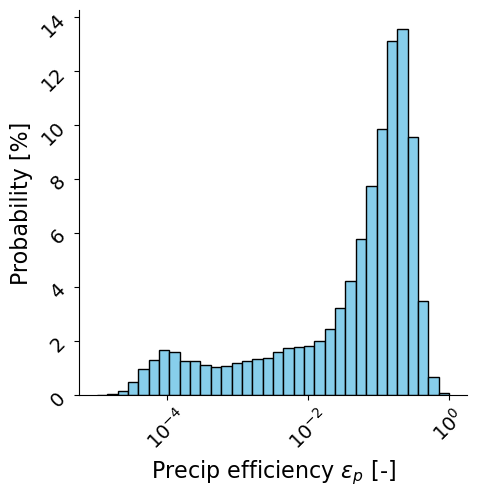

In [15]:
fig = plt.figure( figsize=(5,5) )
fs = 16
ep = precip_eff_HadGEM.values.flatten()
wgts = np.ones_like( ep )/float( len( ep ) )*100
plt.hist( ep, weights=wgts, bins=np.logspace(-5,0,35), color='skyblue', edgecolor='black' )
plt.gca().set_xscale( 'log' )
plt.ylabel( 'Probability [%]', fontsize=fs )
plt.xlabel( r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs )
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params( axis='both', rotation=45, labelsize=fs-2 )

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/DYAMOND_HadGEM_3D-precipeff_histogram_timeavg_nobounds_PLfull_Asia.pdf',
#    bbox_inches='tight' )

In [13]:
def resize_colorbar(event):
    plt.draw()

    posn = ax.get_position()
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                          0.04, posn.height])

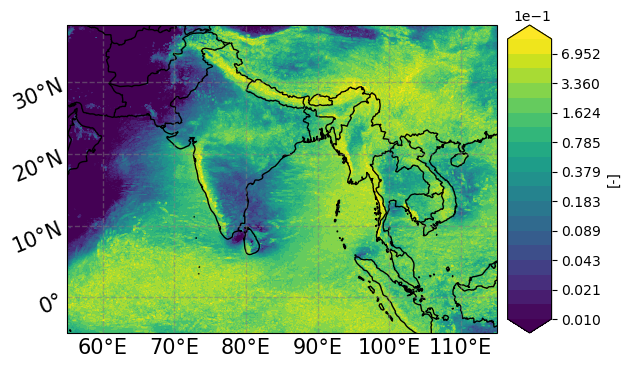

In [14]:
minval = -3
maxval = 0
levs = np.logspace( minval, maxval, 20 ) 

fig, ax = plt.subplots( 1, 1, figsize=(11,4),
                      subplot_kw={'projection': ccrs.PlateCarree()})  
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
ax.set_extent( [55, 115, -5, 38], crs=ccrs.PlateCarree() )

im = ax.contourf( lons, lats, precip_eff_HadGEM, levels=levs, cmap='viridis', extend='both', 
                norm=colors.LogNorm(vmin=10**minval, vmax=10**maxval) )
ax.coastlines()
ax.add_feature( cf.BORDERS )

gl = ax.gridlines( crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--' )
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = { 'size':15 }
gl.ylabel_style = { 'size':15, 'rotation':35 }

fig.canvas.mpl_connect('resize_event', resize_colorbar)

# Colorbar labeling in scientific notation - option 1
#plt.colorbar( im, label=r'[s$^{-1}$]', cax=cbar_ax, format=matplotlib.ticker.FuncFormatter(fmt) )

# Colorbar labeling in scientific notation - option 2
cbar = plt.colorbar( im, label='[-]', cax=cbar_ax )
cbar.formatter.set_scientific( True )
cbar.formatter.set_powerlimits( (0,0) )
resize_colorbar(None)

fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/DYAMOND_HadGEM_3D-precipeff_map_timeavg_avgbounds_PLfull_Asia.pdf',
            bbox_inches='tight' )

### Dask workflow (not needed in the end) - Job and client details for dask

In [ ]:
## Set up a dask cluster so that commands use multiple cores at the same time
import dask # Distributed data libary
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from distributed import Client, LocalCluster, progress, wait # Libaray to orchestrate distributed resources
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs

In [ ]:
# Set some user specific variables
account_name = 'sylvia'
partition = 'high_priority'
job_name = 'geos-pe' # Job name that is submitted via sbatch
memory = '200GiB' # Max memory per node that is going to be used - this depends on the partition
cores = 16 # Max number of cores per that are reserved - also partition dependent
walltime = '01:00:00' #'12:00:00' # Walltime - also partition dependent

In [ ]:
scratch_dir = '/xdisk/sylvia/DYAMOND-UM/' # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_scratch_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=partition,
                       name=job_name,
                       processes=8,
                       scheduler_options={'dashboard_address': ':12435'},
                       local_directory=dask_scratch_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_scratch_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_scratch_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_scratch_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='eth0')

In [ ]:
# What does the job request that I just built look like?
print(cluster.job_script())

In [ ]:
cluster = LocalCluster()
client = Client(cluster)
client

In [ ]:
print(np.nanmean(peff_HadGEM))